In [12]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
import numpy as np
from keras.optimizers import SGD, Adam


# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize the data
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Split 10% of x_train and y_train for validation
validation_split = 0.2
val_size = int(validation_split * x_train.shape[0])

x_val = x_train[:val_size]
y_val = y_train[:val_size]
x_train = x_train[val_size:]
y_train = y_train[val_size:]

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)

mean=np.mean(x_train)
std=np.std(x_train)
x_test=(x_test-mean)/std
x_train=(x_train-mean)/std

print(f"Training data shape: {x_train.shape}, Validation data shape: {x_val.shape}")

# Data augmentation

num_filters = 32
reg_rate = 0.01

# Build the model
model = models.Sequential()

# Block 1
model.add(layers.Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(num_filters, (3, 3), activation='relu',kernel_initializer='he_uniform', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.2))

# Block 2
model.add(layers.Conv2D(num_filters*2, (3, 3), activation='relu',kernel_initializer='he_uniform', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(num_filters*2, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.3))

# Block 3
model.add(layers.Conv2D(num_filters*4, (3, 3), activation='relu',kernel_initializer='he_uniform', padding='same'))
model.add(layers.BatchNormalization())
# model.add(layers.Conv2D(num_filters*8, (3, 3), activation='relu',kernel_initializer='he_uniform', padding='same'))
# model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.3))

# # Block 3
# model.add(layers.Conv2D(num_filters*8, (3, 3), activation='relu',kernel_initializer='he_uniform', padding='same'))
# model.add(layers.BatchNormalization())
# model.add(layers.Conv2D(num_filters*8, (3, 3), activation='relu',kernel_initializer='he_uniform', padding='same'))
# model.add(layers.BatchNormalization())
# model.add(layers.MaxPooling2D((2,2)))
# model.add(layers.Dropout(0.5))

# model.add(layers.GlobalAveragePooling2D())
# model.add(layers.Dense(num_filters*16, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(num_filters*16, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
# model.add(layers.Dropout(0.6))
# model.add(layers.Dense(10, activation='softmax'))

# model.add(layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
# # model.add(BatchNormalization())
# model.add(layers.Dropout(0.6))  # Adjust dropout for this layer

model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.001)))
# model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

model.summary()


Training data shape: (40000, 32, 32, 3), Validation data shape: (10000, 32, 32, 3)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_27 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_31 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_28 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                

In [14]:
# Compile the model
# opt = optimizers.Nadam(learning_rate=0.0001)

opt=Adam(learning_rate=0.0025,decay=0.0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, min_lr=1e-7)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,         # Stop after 10 epochs with no improvement
    restore_best_weights=True  # Restore weights of the best epoch
)


# Train the model
history = model.fit(
    # datagen.flow(x_train, y_train, batch_size=128),
    x_train,
    y_train,
    # validation_data=(x_val, y_val), 
    validation_split = 0.2,
    epochs=150,
    callbacks=[early_stopping,reduce_lr]
)

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc * 100:.2f}%")


Epoch 1/150
   6/1000 [..............................] - ETA: 11s - loss: 5.5844 - accuracy: 0.1302  

2025-01-23 22:13:54.170946: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_11/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1000/1000 [==============================] - 14s 13ms/step - loss: 2.1082 - accuracy: 0.4190 - val_loss: 1.6099 - val_accuracy: 0.5065 - lr: 0.0025
Epoch 2/150
1000/1000 [==============================] - 13s 13ms/step - loss: 1.5171 - accuracy: 0.5540 - val_loss: 1.4501 - val_accuracy: 0.5671 - lr: 0.0025
Epoch 3/150
1000/1000 [==============================] - 13s 13ms/step - loss: 1.3894 - accuracy: 0.6014 - val_loss: 1.3147 - val_accuracy: 0.6196 - lr: 0.0025
Epoch 4/150
1000/1000 [==============================] - 13s 13ms/step - loss: 1.3061 - accuracy: 0.6314 - val_loss: 1.1905 - val_accuracy: 0.6689 - lr: 0.0025
Epoch 5/150
1000/1000 [==============================] - 13s 13ms/step - loss: 1.2491 - accuracy: 0.6564 - val_loss: 1.1036 - val_accuracy: 0.6964 - lr: 0.0025
Epoch 6/150
1000/1000 [==============================] - 13s 13ms/step - loss: 1.1990 - accuracy: 0.6755 - val_loss: 1.1460 - val_accuracy: 0.6892 - lr: 0.0025
Epoch 7/150
1000/1000 [=============================

In [20]:
# Save the model (architecture + weights + optimizer state)
model.save('models/base_model.h5')  # Saves as HDF5 format



In [16]:

# x_test_norm = 

model2_test_acc=model.evaluate(x_test,y_test)
model2_test_acc
print("params:",model.count_params())
# model.summary()


313/313 [==============================] - 2s 7ms/step - loss: 0.5150 - accuracy: 0.8409
params: 211882


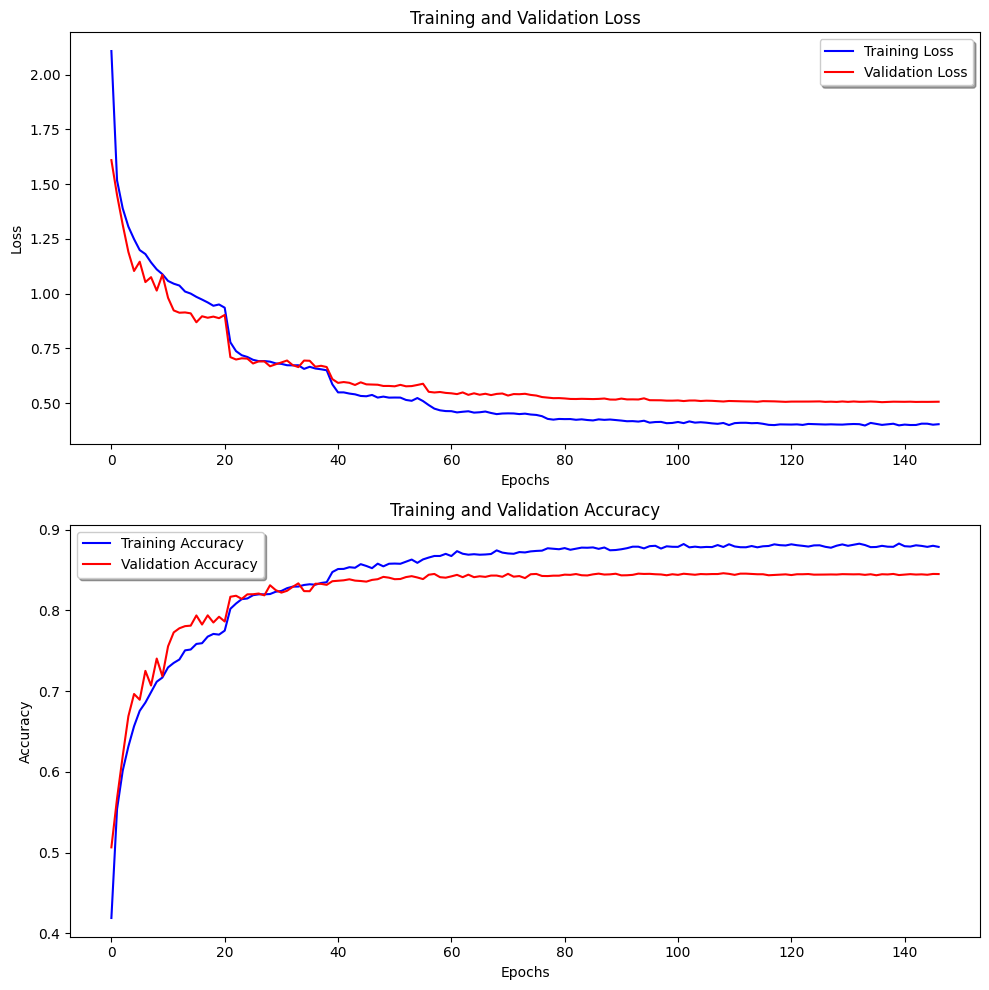

In [17]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# Plot training and validation loss
ax[0].plot(history.history['loss'], color='b', label="Training Loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation Loss")
ax[0].legend(loc='best', shadow=True)
ax[0].set_title("Training and Validation Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")

# Plot training and validation accuracy
ax[1].plot(history.history['accuracy'], color='b', label="Training Accuracy")
ax[1].plot(history.history['val_accuracy'], color='r', label="Validation Accuracy")
ax[1].legend(loc='best', shadow=True)
ax[1].set_title("Training and Validation Accuracy")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")

plt.tight_layout()
plt.show()

In [18]:
# from tensorflow.keras.models import load_model

# # Load the model
# model_sui = load_model('models/model_emai_90_2M_rgb.h5')

# testing = model_sui.evaluate(x_test,y_test)
